##  Validation

Validate results using Deep Carto package against results using mlcolvars

This notebook can be used for debugging purposes and to understand how is mlcovars used from Deep Carto

In [1]:
from deep_cartograph.run import deep_cartograph 
import importlib.resources as resources
from deep_cartograph import data

from typing import Literal
import pandas as pd
import numpy as np
import logging
import shutil
import yaml
import os

# Get the path to the data
data_folder = resources.files(data)

# Set logging level
logging.basicConfig(level=logging.INFO)

def run_deep_carto(features: Literal['torsions', 'distances'], system_name: str, output_folder: str):
    """
    
    Run the deep_cartograph workflow for a given system and feature set.
    
    Parameters
    ----------
    
    features : Literal['torsions', 'distances']
        The feature set to use.
    
    system_name : str
        The name of the system to analyze.
        
    output_folder : str

    """
    
    # Input trajectory and topology
    input_path = f"{data_folder}/calpha_transitions/input/{system_name}"
    traj_path = os.path.join(input_path, f'{system_name}.dcd')
    top_path = os.path.join(input_path, f'{system_name}.pdb')

    # Input configuration
    # config_path = f"{data_folder}/calpha_transitions/input/{features}_config_validation.yml"
    config_path = f"{features}_config_validation.yml"
    
    with open(config_path) as config_file:
        configuration = yaml.load(config_file, Loader = yaml.FullLoader)

    # Clean output folder
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)

    ################
    # Run workflow #
    ################
    deep_cartograph(
        configuration = configuration,
        trajectory_data = traj_path,
        topology_data = top_path,
        output_folder = output_folder)

    return

/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Deep Carto results

For distance and torsion angle features

In [2]:
output_folder = 'output_master'
system_name = '1rcs_B-3ssx_R-3'
features = 'distances'
output_path = f"{output_folder}/{system_name}/{features}"

run_deep_carto(features, system_name, output_path)

/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
INFO:deep_cartograph:================
INFO:deep_cartograph:Analyze geometry
INFO:deep_cartograph:======

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## mlcolvars results

Here we load the same colvars files and we use the mlcolvars package directly

In [3]:
from deep_cartograph.modules.common import read_feature_constraints
from deep_cartograph.modules.figures import figures

from mlcolvar.utils.timelagged import create_timelagged_dataset
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.utils.trainer import MetricsCallback
from mlcolvar.utils.plot import plot_metrics
from mlcolvar.core.transform.utils import Statistics
from mlcolvar.core.transform import Normalization
from mlcolvar.data import DictModule
from mlcolvar.cvs import AutoEncoderCV, DeepTICA
from mlcolvar.core.stats import PCA, TICA

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

import lightning 
import torch

In [4]:
# Path to output
parent_output_path = 'output_mlcolvars'
output_path = os.path.join(parent_output_path, system_name, features)

# Create output path
os.makedirs(output_path, exist_ok=True)

features='distances' 

# Path to features
colvars_path = f"{output_folder}/{system_name}/{features}/compute_features/{system_name}/colvars.dat"

# Find filtered features
filtered_features_path = f"{output_folder}/{system_name}/{features}/filter_features/filtered_features.txt"
feature_list = read_feature_constraints(filtered_features_path)
feature_filter = dict(items=feature_list)

# Create training dataset
training_input_dtset = create_dataset_from_files(file_names=colvars_path, filter_args=feature_filter, verbose=False, return_dataframe=False)

# Find number of features
num_features = training_input_dtset["data"].shape[1]
        
# Compute normalization layer using training data statistics
training_data_stats = Statistics(training_input_dtset[:]['data']).to_dict()
features_normalization = Normalization(num_features, mean=training_data_stats["mean"], range=training_data_stats["std"])
features_mean = training_data_stats["mean"]
features_std = training_data_stats["std"]

# Normalize data
normalized_training_data = features_normalization(training_input_dtset[:]['data'])

# Create time-lagged dataset 
normalized_lagged_training_data = create_timelagged_dataset(normalized_training_data.numpy(), lag_time=1)

# Save mean and std 
np.savetxt(os.path.join(output_path, 'features_mean.txt'), features_mean)
np.savetxt(os.path.join(output_path, 'features_std.txt'), features_std)

INFO:deep_cartograph.modules.common.common: Using features in output_master/1rcs_B-3ssx_R-3/distances/filter_features/filtered_features.txt
/home/pnavarro/repos/mlcolvar/mlcolvar/utils/timelagged.py:140: UserWarning: Monitoring the progress for the search of time-lagged configurations with a progress_bar requires `tqdm`.
  warnings.warn(


### PCA

In [5]:
output_path = os.path.join(parent_output_path, system_name, features, 'pca')

# Create output folder
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Compute PCA
pca_obj = PCA(in_features=num_features)
pca_eigvals, pca_eigvecs = pca_obj.compute(X=torch.tensor(normalized_training_data.numpy()), center = True)
pca_cv =  pca_eigvecs[:,0:2].numpy()
np.savetxt(os.path.join(output_path, f'weights.txt'), pca_cv)

# Project the training data
projected_training_data = np.matmul(normalized_training_data.numpy(), pca_cv)

# Compute statistics of the projected training data
stats = Statistics(torch.tensor(projected_training_data))

# Find the normalization for the CV space
cv_normalization = Normalization(2, mode='min_max', stats = stats)

# Normalize the projected training data in the CV space
normalized_projected_training_data = cv_normalization(torch.tensor(projected_training_data)).numpy()

# Convert to pandas dataframe
projected_colvars_df = pd.DataFrame(normalized_projected_training_data, columns=['PC 1', 'PC 2'])

# Save in csv file
projected_colvars_df.to_csv(os.path.join(output_path, 'projected_trajectory.csv'), index=False, float_format='%.4f')

# Add a column with the order of the data points
projected_colvars_df['order'] = np.arange(projected_colvars_df.shape[0])

figure_settings = {
    'plot': True,
    'num_bins': 100,
    'bandwidth': 0.25,
    'alpha': 0.6,
    'cmap': 'turbo',
    'use_legend': True,
    'marker_size': 12,
}

figures.gradient_scatter_plot(
    data = projected_colvars_df,
    column_labels = ['PC 1', 'PC 2'],
    color_label = 'order',
    settings = figure_settings,
    file_path = os.path.join(output_path,'trajectory.png'))
                        
# Save the max and min values for each dimension
stats_dict = stats.to_dict()
np.savetxt(os.path.join(output_path, 'cv_max.txt'), stats_dict['max'])
np.savetxt(os.path.join(output_path, 'cv_min.txt'), stats_dict['min'])

### TICA

In [6]:
output_path = os.path.join(parent_output_path, system_name, features, 'tica')

# Create output folder
if not os.path.exists(output_path):
    os.makedirs(output_path)
    
# Compute TICA
tica_obj = TICA(in_features = num_features, out_features=2)
tica_eigvals, tica_eigvecs = tica_obj.compute(data=[normalized_lagged_training_data['data'], normalized_lagged_training_data['data_lag']], save_params = True, remove_average = True)
tica_cv = tica_eigvecs.numpy() 
np.savetxt(os.path.join(output_path, f'weights.txt'), tica_cv)

# Project the training data
projected_training_data = np.matmul(normalized_training_data.numpy(), tica_cv)

# Compute statistics of the projected training data
stats = Statistics(torch.tensor(projected_training_data))

# Find the normalization for the CV space
cv_normalization = Normalization(2, mode='min_max', stats = stats)

# Normalize the projected training data in the CV space
normalized_projected_training_data = cv_normalization(torch.tensor(projected_training_data)).numpy()

# Convert to pandas dataframe
projected_colvars_df = pd.DataFrame(normalized_projected_training_data, columns=['TIC 1', 'TIC 2'])

# Save in csv file
projected_colvars_df.to_csv(os.path.join(output_path, 'projected_trajectory.csv'), index=False, float_format='%.4f')

# Add a column with the order of the data points
projected_colvars_df['order'] = np.arange(projected_colvars_df.shape[0])

figure_settings = {
    'plot': True,
    'num_bins': 100,
    'bandwidth': 0.25,
    'alpha': 0.6,
    'cmap': 'turbo',
    'use_legend': True,
    'marker_size': 12,
}

figures.gradient_scatter_plot(
    data = projected_colvars_df,
    column_labels = ['TIC 1', 'TIC 2'],
    color_label = 'order',
    settings = figure_settings,
    file_path = os.path.join(output_path,'trajectory.png'))
                     
# Save the max and min values for each dimension
stats_dict = stats.to_dict()
np.savetxt(os.path.join(output_path, 'cv_max.txt'), stats_dict['max'])
np.savetxt(os.path.join(output_path, 'cv_min.txt'), stats_dict['min'])

### Autoencoder

In [7]:
output_path = os.path.join(parent_output_path, system_name, features, 'ae')

# Create output folder
if not os.path.exists(output_path):
    os.makedirs(output_path)
    
# Create datamodule for trainings
datamodule = DictModule(
    random_split = True,
    dataset = training_input_dtset,
    lengths = [0.8, 0.2],
    batch_size = 128,
    shuffle = False, 
    generator = torch.manual_seed(42))

# Define layers
hidden_layers = [5, 3]
nn_layers =  [num_features] + hidden_layers + [2]

# Define options
options = {
    "norm_in" : {'mode' : 'mean_std'},
    "encoder": {'activation': 'shifted_softplus', 'dropout': 0.1},
    "decoder": {'activation': 'shifted_softplus', 'dropout': 0.1},
    "optimizer": {'lr': 1e-3, 'weight_decay': 0}
}

# Compute Autoencoder
ae = AutoEncoderCV(nn_layers,  options=options)

# Set optimizer
ae._optimizer_name = 'Adam'

# Define MetricsCallback to store the loss
metrics = MetricsCallback()

# Define EarlyStopping callback to stop training
early_stopping = EarlyStopping(
    monitor="valid_loss", 
    min_delta=1.0e-05, 
    patience=100, 
    mode = "min")

# Define ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    dirpath=output_path,
    monitor="valid_loss",                    
    save_last=False,                          
    save_top_k=1,                             
    save_weights_only=True,                   
    filename=None,                            
    mode="min",                                
    every_n_epochs=1)

# Define trainer
trainer = lightning.Trainer(          
    callbacks=[metrics, early_stopping, checkpoint],
    max_epochs=10000, 
    logger=False, 
    enable_checkpointing=True,
    enable_progress_bar = False, 
    check_val_every_n_epoch=1)

trainer.fit(ae, datamodule)

# Load the best model
best_model = AutoEncoderCV.load_from_checkpoint(checkpoint.best_model_path)

# Find the score
best_model_score = checkpoint.best_model_score
print(f'Best model score: {best_model_score}')

ax = plot_metrics(metrics.metrics, 
                    labels=['Training', 'Validation'], 
                    keys=['train_loss', 'valid_loss'], 
                    linestyles=['-','-'], colors=['fessa1','fessa5'], 
                    yscale='log')            
# Save figure
ax.figure.savefig(os.path.join(output_path, f'loss.png'), dpi=300, bbox_inches='tight')
ax.figure.clf()

# After training, put model in evaluation mode - needed for cv normalization and data projection
best_model.eval()

# Data projected onto original latent space of the best model - feature normalization included in the model
with torch.no_grad():
    best_model.postprocessing = None
    projected_training_data = best_model(training_input_dtset[:]['data'])
    
# Compute statistics of the projected training data
stats = Statistics(projected_training_data)

# Find the normalization for the CV space
cv_normalization = Normalization(2, mode='min_max', stats = stats)

# Set the normalization postprocessing layer of the model
best_model.postprocessing = cv_normalization

# Data projected onto normalized latent space - feature and latent space normalization included in the model
with torch.no_grad():
    normalized_projected_training_data = best_model(training_input_dtset[:]['data']).numpy()

# Convert to pandas dataframe
projected_colvars_df = pd.DataFrame(normalized_projected_training_data, columns=['AE 1', 'AE 2'])

# Save in csv file
projected_colvars_df.to_csv(os.path.join(output_path, 'projected_trajectory.csv'), index=False, float_format='%.4f')

# Add a column with the order of the data points
projected_colvars_df['order'] = np.arange(projected_colvars_df.shape[0])

figure_settings = {
    'plot': True,
    'num_bins': 100,
    'bandwidth': 0.25,
    'alpha': 0.6,
    'cmap': 'turbo',
    'use_legend': True,
    'marker_size': 12,
}
"""
figures.gradient_scatter_plot(
    data = projected_colvars_df,
    column_labels = ['AE 1', 'AE 2'],
    color_label = 'order',
    settings = figure_settings,
    file_path = os.path.join(output_path,'trajectory.png'))
"""
# The projection should be min max normalized, check it here
projected_data_stats = Statistics(torch.tensor(normalized_projected_training_data))
projected_data_stats_dict = projected_data_stats.to_dict()
np.savetxt(os.path.join(output_path, 'cv_max.txt'), projected_data_stats_dict['max'])
np.savetxt(os.path.join(output_path, 'cv_min.txt'), projected_data_stats_dict['min'])

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/pnavarro/repos/NBDsoftware/deep_cartograph/examples/notebooks/4.validation/output_mlcolvars/1rcs_B-3ssx_R-3/distances/ae exists and is not empty.
INFO: 
  | Name    | Type          | Params | Mode  | In sizes | Out sizes
-------------------------------------------------------------------------
0 | loss_fn | MSELoss       | 0      | train | ?        | ?        
1 | norm_in | Normalization | 0      | train | [1, 41]  | [1, 41]  
2 | encoder | FeedForward   | 236    | train | [

Best model score: 0.006817468907684088


<Figure size 500x400 with 0 Axes>

### Deep TICA

In [9]:
output_path = os.path.join(parent_output_path, system_name, features, 'deep_tica')

# Create time-lagged dataset (composed by pairs of samples at time t, t+lag)
lagged_training_input_dtset = create_timelagged_dataset(training_input_dtset[:]['data'].numpy(), lag_time=1)
        
# Create output folder
if not os.path.exists(output_path):
    os.makedirs(output_path)
    
# Create datamodule for trainings
datamodule = DictModule(
    random_split = True,
    dataset = lagged_training_input_dtset,
    lengths = [0.8, 0.2],
    batch_size = 128,
    shuffle = False, 
    generator = torch.manual_seed(42))

# Define layers
nn_layers =  [num_features] + hidden_layers + [2]

# Define options
options = {
    "norm_in" : {'mode' : 'mean_std'},
    "nn": {'activation': 'shifted_softplus', 'dropout': 0.1},
    "optimizer": {'lr': 1e-3, 'weight_decay': 0}
}

dtica = DeepTICA(nn_layers,  options=options)

# Set optimizer
dtica._optimizer_name = 'Adam'

# Define MetricsCallback to store the loss
metrics = MetricsCallback()

# Define EarlyStopping callback to stop training
early_stopping = EarlyStopping(
    monitor="valid_loss", 
    min_delta=1.0e-05, 
    patience=100, 
    mode = "min")

# Define ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    dirpath=output_path,
    monitor="valid_loss",                    
    save_last=False,                          
    save_top_k=1,                             
    save_weights_only=True,                   
    filename=None,                            
    mode="min",                                
    every_n_epochs=1)

# Define trainer
trainer = lightning.Trainer(          
    callbacks=[metrics, early_stopping, checkpoint],
    max_epochs=10000, 
    logger=False, 
    enable_checkpointing=True,
    enable_progress_bar = False, 
    check_val_every_n_epoch=1)

trainer.fit(dtica, datamodule)

# Load the best model
best_model = DeepTICA.load_from_checkpoint(checkpoint.best_model_path)

# Find the score
best_model_score = checkpoint.best_model_score
print(f'Best model score: {best_model_score}')

ax = plot_metrics(metrics.metrics,
                    labels=['Training', 'Validation'], 
                    keys=['train_loss', 'valid_loss'], 
                    linestyles=['-','-'], colors=['fessa1','fessa5'], 
                    yscale='log')

# Save figure
ax.figure.savefig(os.path.join(output_path, f'loss.png'), dpi=300, bbox_inches='tight')
ax.figure.clf()

# After training, put model in evaluation mode - needed for cv normalization and data projection
best_model.eval()

# Data projected onto original latent space of the best model - feature normalization included in the model
with torch.no_grad():
    best_model.postprocessing = None
    projected_training_data = best_model(lagged_training_input_dtset[:]['data'])
    
# Compute statistics of the projected training data
stats = Statistics(projected_training_data)

# Find the normalization for the CV space
cv_normalization = Normalization(2, mode='min_max', stats = stats)

# Set the normalization postprocessing layer of the model
best_model.postprocessing = cv_normalization

# Find the epoch where the best model was found
best_index = metrics.metrics['valid_loss'].index(best_model_score)
best_epoch = metrics.metrics['epoch'][best_index]

# Find eigenvalues of the best model
best_eigvals = [metrics.metrics[f'valid_eigval_{i+1}'][best_index] for i in range(2)]
for i in range(2):
    print(f'Eigenvalue {i+1}: {best_eigvals[i]}')

np.savetxt(os.path.join(output_path, 'eigenvalues.txt'), np.array(best_eigvals))

# Plot eigenvalues
ax = plot_metrics(metrics.metrics,
                    labels=[f'Eigenvalue {i+1}' for i in range(2)], 
                    keys=[f'valid_eigval_{i+1}' for i in range(2)],
                    ylabel='Eigenvalue',
                    yscale=None)

# Save figure
ax.figure.savefig(os.path.join(output_path, f'eigenvalues.png'), dpi=300, bbox_inches='tight')
ax.figure.clf()

# Data projected onto normalized latent space - feature and latent space normalization included in the model
with torch.no_grad():
    normalized_projected_training_data = best_model(lagged_training_input_dtset[:]['data']).numpy()

# Convert to pandas dataframe
projected_colvars_df = pd.DataFrame(normalized_projected_training_data, columns=['Deep TIC 1', 'Deep TIC 2'])

# Save in csv file
projected_colvars_df.to_csv(os.path.join(output_path, 'projected_trajectory.csv'), index=False, float_format='%.4f')    

# Add a column with the order of the data points
projected_colvars_df['order'] = np.arange(projected_colvars_df.shape[0])

figure_settings = {
    'plot': True,
    'num_bins': 100,
    'bandwidth': 0.25,
    'alpha': 0.6,
    'cmap': 'turbo',
    'use_legend': True,
    'marker_size': 12,
}

figures.gradient_scatter_plot(
    data = projected_colvars_df,
    column_labels = ['Deep TIC 1', 'Deep TIC 2'],
    color_label = 'order',
    settings = figure_settings,
    file_path = os.path.join(output_path,'trajectory.png'))

# The projection should be min max normalized, check it here
projected_data_stats = Statistics(torch.tensor(normalized_projected_training_data))
projected_data_stats_dict = projected_data_stats.to_dict()
np.savetxt(os.path.join(output_path, 'cv_max.txt'), projected_data_stats_dict['max'])
np.savetxt(os.path.join(output_path, 'cv_min.txt'), projected_data_stats_dict['min'])

/home/pnavarro/repos/mlcolvar/mlcolvar/utils/timelagged.py:140: UserWarning: Monitoring the progress for the search of time-lagged configurations with a progress_bar requires `tqdm`.
  warnings.warn(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/pnavarro/repos/NBDsoftware/deep_cartograph/examples/notebooks/4.validation/output_mlcolvars/1rcs_B-3ssx_R-3/distances/deep_tica exists and is not empty.
INFO: 
  | Name    | Type                  | Params | Mode  | In sizes | Out sizes
-------------------------------------------

INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type                  | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------------------
0 | loss_fn | ReduceEigenvaluesLoss | 0      | train | ?        | ?        
1 | norm_in | Normalization         | 0      | train | [1, 41]  | [1, 41]  
2 | nn      | FeedForward           | 236    | train | [1, 41]  | [1, 2]   
3 | tica    | TICA                  | 0      | train | [1, 2]   | [1, 2]   
---------------------------------------------------------------------------------
236       Trainable params
0         Non-trainable params
236       Total params
0.001     Total estimated model params size (MB)


Best model score: -1.968808650970459


/home/pnavarro/repos/mlcolvar/mlcolvar/utils/plot.py:254: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)


Eigenvalue 1: 1.0133341550827026
Eigenvalue 2: 0.970547616481781


<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

## PyEMMA results

### PCA

/home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "pca". Called from /home/pnavarro/.conda/envs/deep_cartograph/lib/python3.10/site-packages/decorator.py line 232. Use sklearn.decomposition.PCA instead.
  return caller(func, *(extras + args), **kw)


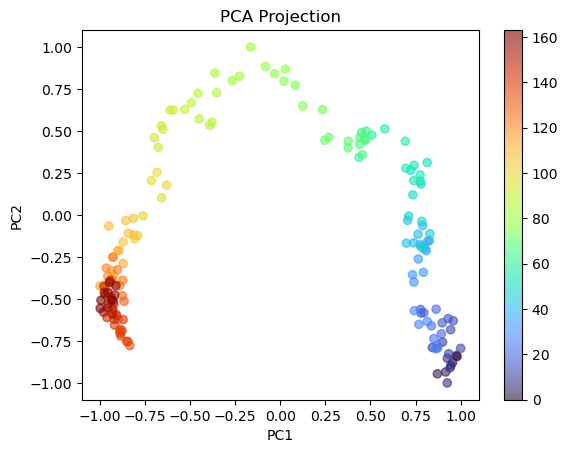

In [13]:
import pyemma 
import matplotlib.pyplot as plt

# Path to output
parent_output_path = 'output_pyemma'
output_path = os.path.join(parent_output_path, system_name, features)

# Create output path
os.makedirs(output_path, exist_ok=True)

# normalized data
data = normalized_training_data.numpy()

# Perform PCA
pca = pyemma.coordinates.pca(data, dim=2)  # Keep 2 principal components

# Project the data onto PCA components
pca_proj = pca.get_output()

# Compute statistics of the projected training data
stats = Statistics(torch.tensor(pca_proj[0]))

# Find the normalization for the CV space
cv_normalization = Normalization(2, mode='min_max', stats = stats)

# Normalize the projected training data in the CV space
normalized_projected_training_data = cv_normalization(torch.tensor(pca_proj[0])).numpy()


# Plot PCA
plt.figure()
plt.scatter(normalized_projected_training_data[:,0], normalized_projected_training_data[:,1], c=np.arange(normalized_projected_training_data.shape[0]), cmap='turbo', alpha=0.6)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection')

plt.show()